<a href="https://colab.research.google.com/github/NandaGoplalNaskar/Pytorch/blob/main/23.11.23_PINNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
# Import necessary libraries
import torch
import torch.nn as nn
import numpy as np
import os
import requests
from time import perf_counter
from PIL import Image
import matplotlib.pyplot as plt
from functools import partial
from IPython.display import display

# Determine computation device: Use GPU if available, else CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



## Example 1: Solving a Single Ordinary Differential Equation (ODE)

Consider the ode:
$$
\frac{d\Psi}{dx} = f(x, \Psi),
$$
with $x \in [0,1]$ and initial conditions (IC):
$$
\Psi(0) = A.
$$
We write the trial solution by:
$$
\hat{\Psi}(x; \theta) = A + x N(x; \theta),
$$
where $N(x; \theta)$ is a neural network (NN).
The solution is $\hat{\Psi}(x;\theta)$ automatically satisfied the initial conditions.
The loss function we would like to minimize to train the NN is:
$$
L(\theta) = \int_0^1 \left[\frac{d\hat{\Psi}(x;\theta)}{dx} - f(x,\hat{\Psi}(x;\theta))\right]^2dx
$$

In [11]:
# Define the neural network architecture (N) as described by Lagaris et al. 1997
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(1, 50)
        self.layer2 = nn.Linear(50, 1, bias=False)

    def forward(self, x):
        x = self.layer1(x)
        x = nn.Sigmoid()(x)
        x = self.layer2(x)
        return x

# Initialize the neural network
N = NeuralNetwork()

# Given initial condition
A = 0.

# Trial solution function using the neural network
Psi_t = lambda x: A + x * N(x)

# Right-hand side of the differential equation
f = lambda x, Psi: torch.exp(-x / 5.0) * torch.cos(x) - Psi / 5.0

# Loss function for training the neural network
def loss(x):
    """Compute the loss based on the discrepancy between the ODE solution and its approximation."""
    x.requires_grad = True
    outputs = Psi_t(x)
    Psi_t_x = torch.autograd.grad(outputs, x, grad_outputs=torch.ones_like(outputs), create_graph=True)[0]
    return torch.mean((Psi_t_x - f(x, outputs)) ** 2)

First, we will use the method that we find in [Lagaris et al](https://arxiv.org/pdf/physics/9705023.pdf).
Instead of using stochastic optimization, they use a lot of points to estimate the loss integral (We will use 100) and then they just do gradient-based optimization (We will do BFGS).

Now, let's use stochastic gradient descent to minimize the loss integral.

In [12]:
# Reinitialize the neural network (N) for fresh training
N = nn.Sequential(
    nn.Linear(1, 50),
    nn.Sigmoid(),
    nn.Linear(50, 1, bias=False)
)

# Define the stochastic optimizer (Adam in this case)
adam_optimizer = torch.optim.Adam(N.parameters(), lr=0.01)

# Define the batch size (number of points to use per iteration) and maximum iterations
n_batch = 5
max_iterations = 1000

# Lists to store iteration and loss values for plotting
iterations = []
loss_values = []

print("Training the neural network...")

# Training loop
for iteration in range(max_iterations):
    # Randomly sample n_batch data points from the interval [0, 2]
    x_batch = 2 * torch.rand(n_batch, 1)

    # Reset the gradients
    adam_optimizer.zero_grad()

    # Compute the loss for the sampled batch
    current_loss = loss(x_batch)

    # Perform backpropagation to compute gradients
    current_loss.backward()

    # Update the neural network parameters
    adam_optimizer.step()

    # Append iteration and loss values for plotting
    iterations.append(iteration + 1)
    loss_values.append(current_loss.item())  # .item() extracts the scalar value from the tensor

    # Print the progress at regular intervals
    if iteration % 100 == 99:
        print(f"Iteration {iteration + 1} completed.")

print("Training completed.")


Training the neural network...
Iteration 100 completed.
Iteration 200 completed.
Iteration 300 completed.
Iteration 400 completed.
Iteration 500 completed.
Iteration 600 completed.
Iteration 700 completed.
Iteration 800 completed.
Iteration 900 completed.
Iteration 1000 completed.
Training completed.


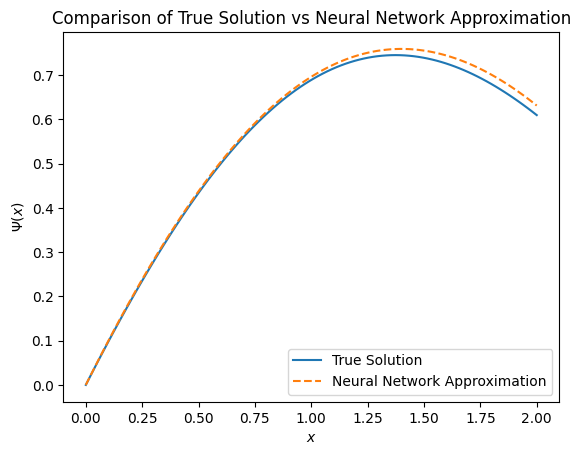

In [13]:
# Generate a range of x-values for evaluating the true solution and its neural network approximation
x_values = np.linspace(0, 2, 100)[:, None]

# Evaluate the neural network's approximation over the generated x-values
with torch.no_grad():
    nn_approximation = Psi_t(torch.Tensor(x_values)).numpy()

# Calculate the true solution over the x-values
true_solution = np.exp(-x_values / 5.0) * np.sin(x_values)

# Plotting the results for comparison
fig, ax = plt.subplots(dpi=100)

# Plot the true solution
ax.plot(x_values, true_solution, label='True Solution')

# Plot the neural network approximation
ax.plot(x_values, nn_approximation, '--', label='Neural Network Approximation')

# Set axis labels and legend
ax.set_xlabel('$x$')
ax.set_ylabel('$\Psi(x)$')
ax.legend(loc='best')
plt.title('Comparison of True Solution vs Neural Network Approximation')
plt.show()

In [14]:
pip install matplotlib


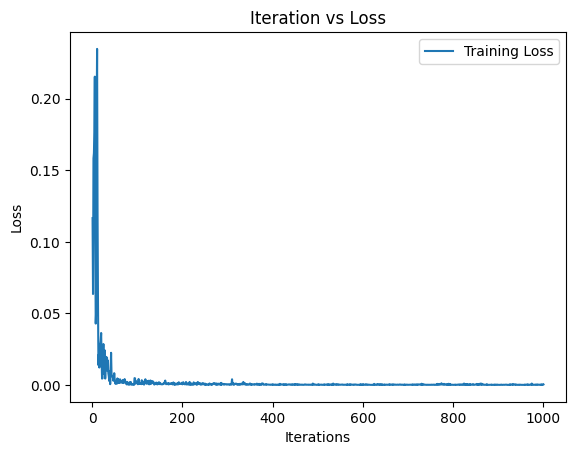

In [15]:
# Plotting the iteration versus loss graph
plt.plot(iterations, loss_values, label="Training Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Iteration vs Loss")
plt.legend()
plt.show()

In [16]:
import numpy as np
from scipy.integrate import solve_ivp

f = lambda x, Psi: np.exp(-x / 5.0) * np.cos(x) - Psi / 5.0

sol = solve_ivp(f, [0, 1], [0], method='RK45')

print(sol.y)


[[0.00000000e+00 9.99979999e-05 1.09975780e-03 1.10751579e-02
  1.08435188e-01 6.88938436e-01]]


Neural Network approximation vs RK45 solution

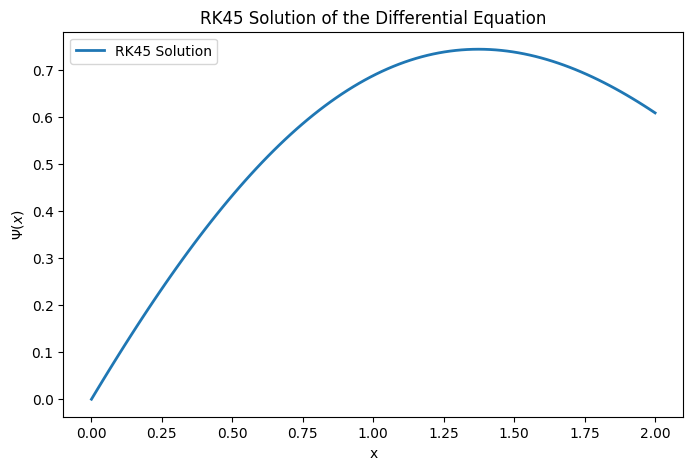

In [17]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Given initial condition
A = 0.

# Define the right-hand side of the differential equation
f = lambda x, Psi: np.exp(-x / 5.0) * np.cos(x) - Psi / 5.0

# Define the RK45 solver function
def ode_system(x, y):
    return f(x, y)

# Initial condition
initial_condition = [A]

# Time span for integration
t_span = (0, 2)

# Solve the ODE using RK45
sol_rk45 = solve_ivp(ode_system, t_span, initial_condition, method='RK45', t_eval=np.linspace(0, 2, 100))

# Plot the RK45 solution
plt.figure(figsize=(8, 5))
plt.plot(sol_rk45.t, sol_rk45.y[0], label='RK45 Solution', linewidth=2)
plt.xlabel('x')
plt.ylabel('$\Psi(x)$')
plt.legend()
plt.title('RK45 Solution of the Differential Equation')
plt.show()


Text(0.5, 1.0, 'Comparison of Neural Network Approximation and RK45 Solution')

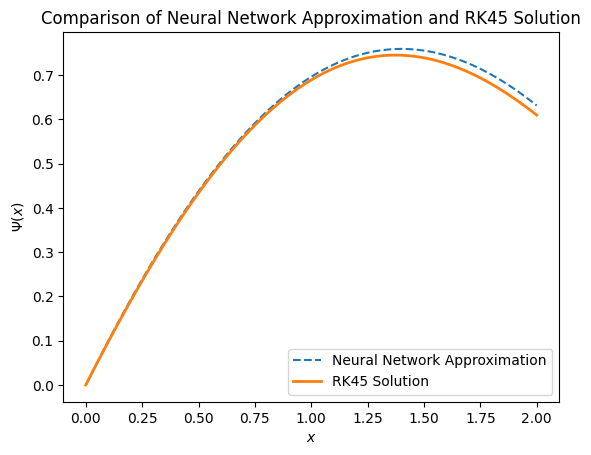

In [18]:
# Generate a range of x-values for evaluating the neural network approximation
x_values = np.linspace(0, 2, 100)[:, None]

# Evaluate the neural network's approximation over the generated x-values
with torch.no_grad():
    nn_approximation = Psi_t(torch.Tensor(x_values)).numpy()

# Plotting the results for comparison
fig, ax = plt.subplots(dpi=100)

# Plot the neural network approximation
ax.plot(x_values, nn_approximation, '--', label='Neural Network Approximation')

# Set axis labels and legend
ax.set_xlabel('$x$')
ax.set_ylabel('$\Psi(x)$')
ax.legend(loc='best')
plt.title('Comparison of Neural Network Approximation and RK45 Solution')

# Solve the ODE using RK45
initial_condition = [A]
t_span = (0, 2)
sol_rk45 = solve_ivp(ode_system, t_span, initial_condition, method='RK45', t_eval=np.linspace(0, 2, 100))

# Plot the RK45 solution
ax.plot(sol_rk45.t, sol_rk45.y[0], label='RK45 Solution', linewidth=2)

# Set axis labels and legend
ax.set_xlabel('$x$')
ax.set_ylabel('$\Psi(x)$')
ax.legend(loc='best')
plt.title('Comparison of Neural Network Approximation and RK45 Solution')

In [19]:
# Define optimizer for the neural network (Algorithm as mentioned by Lagaris)
optimizer = torch.optim.LBFGS(N.parameters())

# Define the collocation points (as used by Lagaris)
x = torch.Tensor(np.linspace(0, 2, 100)[:, None])

# Define the closure function for optimization
def closure():
    """Compute the loss and perform backpropagation."""
    optimizer.zero_grad()
    l = loss(x)
    l.backward()
    return l

# Train the neural network using the optimizer
for i in range(10):
    optimizer.step(closure)

# Compare the neural network's approximation to the true solution
xx = np.linspace(0, 2, 100)[:, None]

with torch.no_grad():
    yy = Psi_t(torch.Tensor(xx)).numpy()

yt = np.exp(-xx / 5.0) * np.sin(xx)

# Plotting the results
fig, ax = plt.subplots(dpi=100)
ax.plot(xx, yt, label='True Solution')
ax.plot(xx, yy, '--', label='Neural Network Approximation')
ax.set_title('Comparison of True Solution vs Neural Network Approximation')
ax.set_xlabel('$x$')
ax.set_ylabel('$\Psi(x)$')
ax.legend(loc='best')
plt.show()

RuntimeError: ignored



---



---



Testing with the real problem

Final values:
x1: 0.7295462422601993
x2: 0.6240143958955232
x3: 0.32577222138663586
x4: 0.8740789883683628
u: 2.9998887207542264


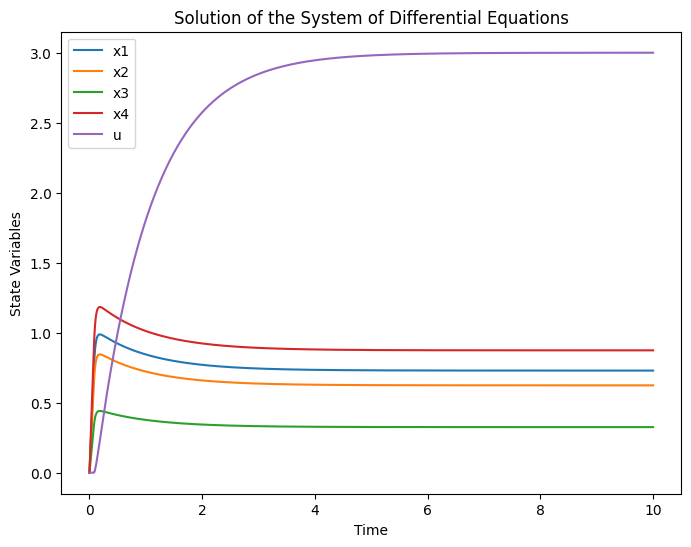

In [20]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Define the system of differential equations
def system(t, y):
    x1, x2, x3, x4, u = y
    dydt = [
       -(-9.54 + max(3.18*(u + 3.18*x1 + 2.72*x2 + 1.42*x3 + 3.81*x4 - 7.81), 0)),
       -(-8.16 + max(2.72*(u + 3.18*x1 + 2.72*x2 + 1.42*x3 + 3.81*x4 - 7.81), 0)),
       -(-4.26 + max(1.42*(u + 3.18*x1 + 2.72*x2 + 1.42*x3 + 3.81*x4 - 7.81), 0)),
       -(-11.43 + max(3.81*(u + 3.18*x1 + 2.72*x2 + 1.42*x3 + 3.81*x4 - 7.81),0)),
        max((u + 3.18*x1 + 2.72*x2 + 1.42*x3 + 3.81*x4 - 7.81), 0) - u
    ]
    return dydt

# Initial condition
initial_condition = [0, 0, 0, 0, 0]

# Time points for output
t_values = np.linspace(0, 10, 1000)

# Solve the system of differential equations using RK45
# sol = solve_ivp(system, t_span=(0, 10), y0=initial_condition, method='RK45', t_eval=t_values)
sol = solve_ivp(system, t_span=(0, 10), y0=initial_condition, method='RK45', t_eval=t_values, rtol=1e-6, atol=1e-8)


# Extract the final values of x1, x2, x3, x4, and u
final_values = sol.y[:, -1]

# Print the final values
print("Final values:")
print("x1:", final_values[0])
print("x2:", final_values[1])
print("x3:", final_values[2])
print("x4:", final_values[3])
print("u:", final_values[4])

# Plot the solutions
plt.figure(figsize=(8, 6))
plt.plot(sol.t, sol.y.T)
plt.xlabel('Time')
plt.ylabel('State Variables')
plt.legend(['x1', 'x2', 'x3', 'x4', 'u'])
plt.title('Solution of the System of Differential Equations')
plt.show()


Training the neural network...
Iteration 100 completed.
Iteration 200 completed.
Iteration 300 completed.
Iteration 400 completed.
Iteration 500 completed.
Iteration 600 completed.
Iteration 700 completed.
Iteration 800 completed.
Iteration 900 completed.
Iteration 1000 completed.
Iteration 1100 completed.
Iteration 1200 completed.
Iteration 1300 completed.
Iteration 1400 completed.
Iteration 1500 completed.
Iteration 1600 completed.
Iteration 1700 completed.
Iteration 1800 completed.
Iteration 1900 completed.
Iteration 2000 completed.
Iteration 2100 completed.
Iteration 2200 completed.
Iteration 2300 completed.
Iteration 2400 completed.
Iteration 2500 completed.
Iteration 2600 completed.
Iteration 2700 completed.
Iteration 2800 completed.
Iteration 2900 completed.
Iteration 3000 completed.
Iteration 3100 completed.
Iteration 3200 completed.
Iteration 3300 completed.
Iteration 3400 completed.
Iteration 3500 completed.
Iteration 3600 completed.
Iteration 3700 completed.
Iteration 3800 c

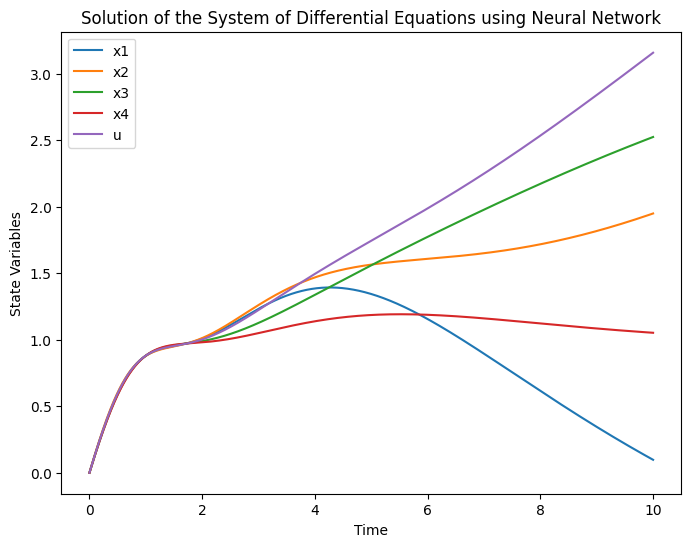

In [30]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Define the neural network architecture
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(1, 100)
        self.layer2 = nn.Linear(100, 5, bias=False)

    def forward(self, x):
        x = self.layer1(x)
        x = nn.Tanh()(x)
        x = self.layer2(x)
        return x

# Initialize the neural network
N = NeuralNetwork()

# Given initial condition
A = torch.Tensor([0, 0, 0, 0, 0])

# Trial solution function using the neural network
Psi_t = lambda x: A + x * N(x)

# Right-hand side of the differential equation
def f(x, Psi):
    x1, x2, x3, x4, u = Psi
    dydt = [
        -(-9.54 + torch.maximum(3.18*(u + 3.18*x1 + 2.72*x2 + 1.42*x3 + 3.81*x4 - 7.81), torch.tensor(0.0))),
        -(-8.16 + torch.maximum(2.72*(u + 3.18*x1 + 2.72*x2 + 1.42*x3 + 3.81*x4 - 7.81), torch.tensor(0.0))),
        -(-4.26 + torch.maximum(1.42*(u + 3.18*x1 + 2.72*x2 + 1.42*x3 + 3.81*x4 - 7.81), torch.tensor(0.0))),
        -(-11.43 + torch.maximum(3.81*(u + 3.18*x1 + 2.72*x2 + 1.42*x3 + 3.81*x4 - 7.81), torch.tensor(0.0))),
        torch.maximum((u + 3.18*x1 + 2.72*x2 + 1.42*x3 + 3.81*x4 - 7.81), torch.tensor(0.0)) - u
    ]

    return torch.stack(dydt)

# Loss function for training the neural network
def loss(x):
    """Compute the loss based on the discrepancy between the ODE solution and its approximation."""
    x.requires_grad = True
    outputs = Psi_t(x)
    Psi_t_x = torch.autograd.grad(outputs, x, grad_outputs=torch.ones_like(outputs), create_graph=True)[0]
    return torch.mean((Psi_t_x - f(x, outputs)) ** 2)

# Reinitialize the neural network (N) for fresh training
N = NeuralNetwork()

# Define the stochastic optimizer (Adam in this case)
adam_optimizer = torch.optim.Adam(N.parameters(), lr=0.001)

# Define the batch size (number of points to use per iteration) and maximum iterations
n_batch = 5
max_iterations = 5000

# Lists to store iteration and loss values for plotting
iterations = []
loss_values = []

print("Training the neural network...")

# Training loop
for iteration in range(max_iterations):
    # Randomly sample n_batch data points from the interval [0, 2]
    x_batch = 2 * torch.rand(n_batch, 1)

    # Reset the gradients
    adam_optimizer.zero_grad()

    # Compute the loss for the sampled batch
    current_loss = loss(x_batch)

    # Perform backpropagation to compute gradients
    current_loss.backward()

    # Update the neural network parameters
    adam_optimizer.step()

    # Append iteration and loss values for plotting
    iterations.append(iteration + 1)
    loss_values.append(current_loss.item())  # .item() extracts the scalar value from the tensor

    # Print the progress at regular intervals
    if iteration % 100 == 99:
        print(f"Iteration {iteration + 1} completed.")

print("Training completed.")

# Time points for output
t_values = np.linspace(0, 10, 1000)
# Use the trained neural network to predict the solution at different time points
y_predicted = Psi_t(torch.Tensor(t_values[:, None])).detach().numpy()

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(t_values, y_predicted)
plt.xlabel('Time')
plt.ylabel('State Variables')
plt.legend(['x1', 'x2', 'x3', 'x4', 'u'])
plt.title('Solution of the System of Differential Equations using Neural Network')
plt.show()


Training the neural network...
Iteration 100 completed. Loss: 9.231812477111816
Iteration 200 completed. Loss: 7.8777971267700195
Iteration 300 completed. Loss: 7.554994106292725
Iteration 400 completed. Loss: 6.889646053314209
Iteration 500 completed. Loss: 6.519559383392334
Iteration 600 completed. Loss: 5.584364414215088
Iteration 700 completed. Loss: 5.448172569274902
Iteration 800 completed. Loss: 5.504975318908691
Iteration 900 completed. Loss: 5.747186183929443
Iteration 1000 completed. Loss: 5.199687957763672
Iteration 1100 completed. Loss: 4.960158824920654
Iteration 1200 completed. Loss: 5.1164422035217285
Iteration 1300 completed. Loss: 5.159400939941406
Iteration 1400 completed. Loss: 4.52430534362793
Iteration 1500 completed. Loss: 3.9274818897247314
Iteration 1600 completed. Loss: 3.5744712352752686
Iteration 1700 completed. Loss: 4.787437438964844
Iteration 1800 completed. Loss: 4.4865522384643555
Iteration 1900 completed. Loss: 3.7645950317382812
Iteration 2000 complete

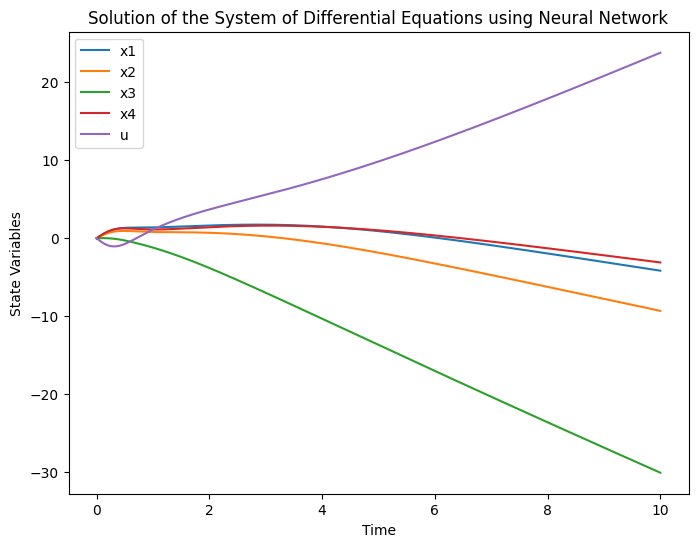

In [37]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Define the neural network architecture
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(1, 100)
        self.layer2 = nn.Linear(100, 5, bias=False)

    def forward(self, x):
        x = self.layer1(x)
        x = nn.Tanh()(x)
        x = self.layer2(x)
        return x

# Initialize the neural network
N = NeuralNetwork()

# Given initial condition
A = torch.Tensor([0, 0, 0, 0, 0])

# Trial solution function using the neural network
Psi_t = lambda x: A + x * N(x)

# Right-hand side of the differential equation
def f(x, Psi):
    u, x1, x2, x3, x4 = Psi[:, 4], Psi[:, 0], Psi[:, 1], Psi[:, 2], Psi[:, 3]
    dydt = [
        -(-9.54 + torch.max(3.18*(u + 3.18*x1 + 2.72*x2 + 1.42*x3 + 3.81*x4 - 7.81), torch.tensor(0.0))),
        -(-8.16 + torch.max(2.72*(u + 3.18*x1 + 2.72*x2 + 1.42*x3 + 3.81*x4 - 7.81), torch.tensor(0.0))),
        -(-4.26 + torch.max(1.42*(u + 3.18*x1 + 2.72*x2 + 1.42*x3 + 3.81*x4 - 7.81), torch.tensor(0.0))),
        -(-11.43 + torch.max(3.81*(u + 3.18*x1 + 2.72*x2 + 1.42*x3 + 3.81*x4 - 7.81), torch.tensor(0.0))),
        torch.max((u + 3.18*x1 + 2.72*x2 + 1.42*x3 + 3.81*x4 - 7.81), torch.tensor(0.0)) - u
    ]

    return torch.stack(dydt, dim=1)  # Use dim=1 to stack along the correct dimension

# Loss function for training the neural network
def loss(x):
    """Compute the loss based on the discrepancy between the ODE solution and its approximation."""
    x.requires_grad = True
    outputs = Psi_t(x)
    Psi_t_x = torch.autograd.grad(outputs, x, grad_outputs=torch.ones_like(outputs), create_graph=True)[0]

    # Ensure the sizes match by using the same batch size
    batch_size = x.shape[0]

    # Compute the loss only for the first 5 components (x1, x2, x3, x4, u)
    current_loss = torch.mean((Psi_t_x[:, :5] - f(x, outputs)) ** 2)

    return current_loss


# Reinitialize the neural network (N) for fresh training
N = NeuralNetwork()

# Define the stochastic optimizer (Adam in this case)
adam_optimizer = torch.optim.Adam(N.parameters(), lr=0.001)

# Define the batch size (number of points to use per iteration) and maximum iterations
n_batch = 128
max_iterations = 5000

# Lists to store iteration and loss values for plotting
iterations = []
loss_values = []

print("Training the neural network...")

# Training loop
for iteration in range(max_iterations):
    # Randomly sample n_batch data points from the interval [0, 2]
    x_batch = 2 * torch.rand(n_batch, 1)

    # Reset the gradients
    adam_optimizer.zero_grad()

    # Compute the loss for the sampled batch
    current_loss = loss(x_batch)

    # Perform backpropagation to compute gradients
    current_loss.backward()

    # Update the neural network parameters
    adam_optimizer.step()

    # Append iteration and loss values for plotting
    iterations.append(iteration + 1)
    loss_values.append(current_loss.item())  # .item() extracts the scalar value from the tensor

    # Print the progress at regular intervals
    if iteration % 100 == 99:
        print(f"Iteration {iteration + 1} completed. Loss: {current_loss.item()}")

print("Training completed.")

# Time points for output
t_values = np.linspace(0, 10, 1000)
# Use the trained neural network to predict the solution at different time points
y_predicted = Psi_t(torch.Tensor(t_values[:, None])).detach().numpy()

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(t_values, y_predicted)
plt.xlabel('Time')
plt.ylabel('State Variables')
plt.legend(['x1', 'x2', 'x3', 'x4', 'u'])
plt.title('Solution of the System of Differential Equations using Neural Network')
plt.show()
